# Setup

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt


from scipy.linalg import eigh

import pandas as pd

import geopandas
import contextily as cx

In [2]:
import pandas as pd 
from ruptures.metrics import hamming

**Utility functions**

In [3]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.margins(x=0)
    return fig, ax

# Question 2

In [4]:
breakpoints = np.array([2, 4, 6, 8, 10])
T = np.array([100, 200, 500, 1000])
sigma = np.array([1, 2, 5, 7])

index = pd.DataFrame({'breakpoints': np.repeat(breakpoints,T.shape[0]*sigma.shape[0]),
              'sample': np.tile(T,(breakpoints.shape[0],sigma.shape[0])).ravel(),
              'sigma': np.tile(np.repeat(sigma,T.shape[0]),breakpoints.shape[0]), 
              })

Signal n° : 0


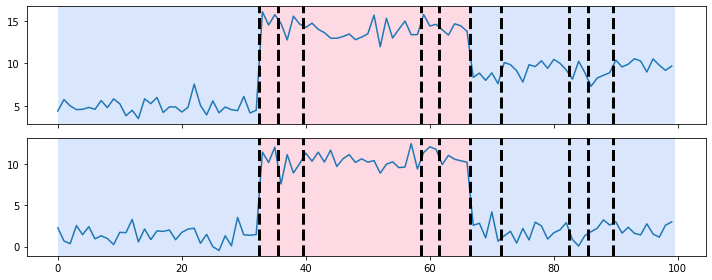

Signal n° : 20


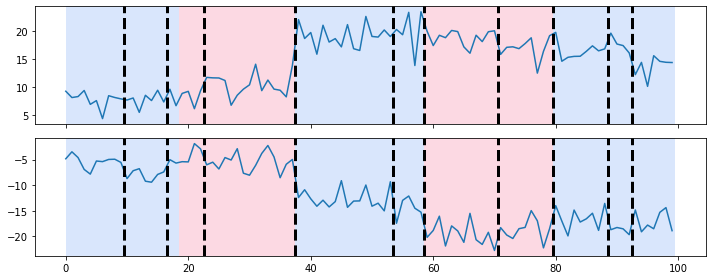

Signal n° : 40


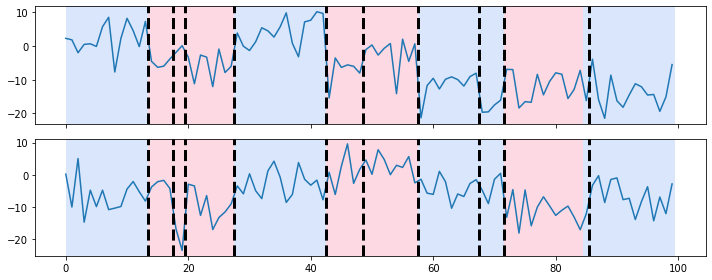

Signal n° : 60


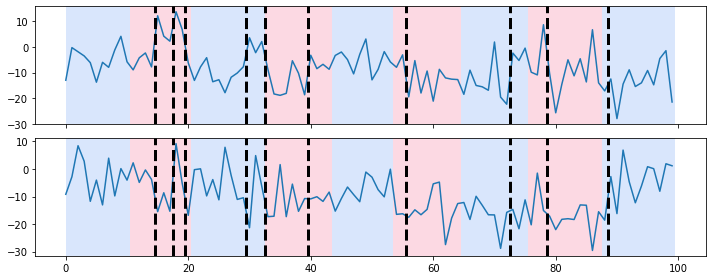

In [5]:
# to detect mean shift, use the faster dynamic programming algorithm in rpt.KernelCPD(kernel="linear")
simulations = {}

n_dims = 2
indices = index.index.values

i = 0 
# generate signal
for indice in indices:
    
    breakpoint, sample, sig = index[index.index == indice].values[0]
    
    signal, bkps = rpt.pw_constant(
        n_samples=sample, n_features=n_dims, n_bkps=breakpoint, noise_std=0
    )
    signal_with_noise = signal + np.random.normal(
        scale=sig, size=signal.shape
    )
        

    algo = rpt.KernelCPD(kernel="linear").fit(signal_with_noise)
            
    result = algo.predict(n_bkps=10)  # detects 10 change-points
            
            
    simulations[str(i), "bkps"] = bkps
    simulations[str(i), "signal"] = signal_with_noise
    simulations[str(i), "result"] = result
            
            
            
    # display
    if i%20 == 0:
        print("Signal n° :", str(i))
        rpt.display(signal_with_noise, bkps, result)
        plt.show()
            
    i+=1

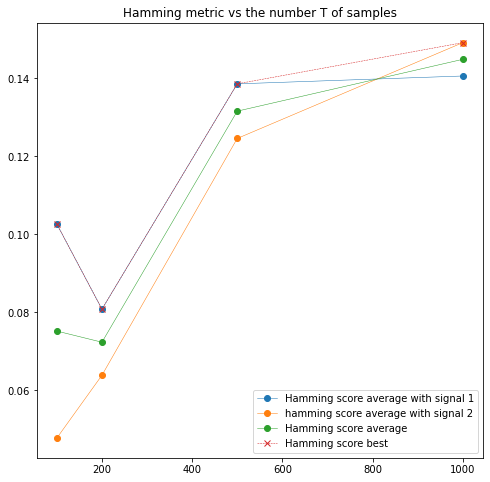

In [6]:
sig = 2

hamming1_List = []
hamming2_List = []

j = 0

for sample in T:
        
        indices = index[(index["sigma"]==sig) & (index["sample"]==sample)].index.values
        
        
        hamming1 = 0
        hamming2 = 0
        
        for i in indices : 
            
            signal_with_noise = simulations[str(i),"signal"]            
            bkps = simulations[str(i),"bkps"] 
        
            algo = rpt.KernelCPD(kernel="linear").fit(signal_with_noise) 
            
            # empiral variance estimator
            signal1_10percent = np.array_split(signal_with_noise[:,0],10)[0]
            signal2_10percent = np.array_split(signal_with_noise[:,1],10)[0]
            
            emp_var1 = signal1_10percent.var()
            emp_var2 = signal2_10percent.var()
            
            # Mallow's Cp
            penalty1 = 2*emp_var1*n_dims
            penalty2 = 2*emp_var2*n_dims
            
            result1 = algo.predict(pen=penalty1)  # minimizes the linearly penalized sum of costs
            result2 = algo.predict(pen=penalty2) 
            
            hamming1 += hamming(bkps,result1)
            hamming2 += hamming(bkps,result2)
            

        
        hamming1_List.append(hamming1/len(indices))
        hamming2_List.append(hamming2/len(indices))
  
        
plt.figure(figsize = (8,8)) 
plt.title("Hamming metric vs the number T of samples")
plt.plot(T,hamming1_List, label = "Hamming score average with signal 1", marker = 'o', linewidth = 0.5) 
plt.plot(T,hamming2_List, label = "hamming score average with signal 2",marker = 'o', linewidth = 0.5) 

average_two_signals = (np.array(hamming1_List) + np.array(hamming2_List))/2
max_two_signals = np.maximum(np.array(hamming1_List),np.array(hamming2_List))

plt.plot(T, average_two_signals, label = "Hamming score average",marker = 'o', linewidth = 0.5)
plt.plot(T, max_two_signals, label = "Hamming score best",marker = 'x', linewidth = 0.5, linestyle ='dashed')
plt.legend()

# saving the figure
plt.savefig(fname="fig-q2-HammingvsSample.png", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)

plt.show()

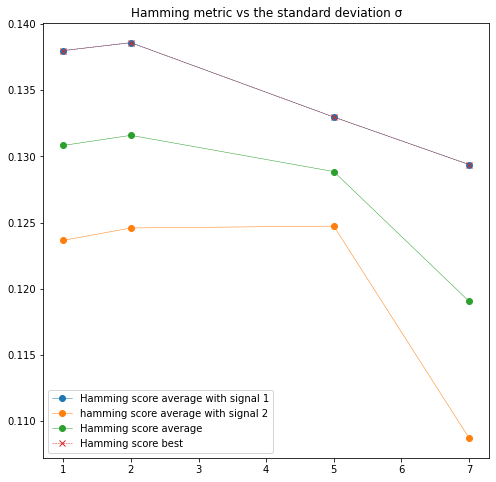

In [7]:
sample = 500

hamming1_List = []
hamming2_List = []

for sig in sigma :
        
        indices = index[(index["sigma"]==sig) & (index["sample"]==sample)].index.values
        
        
        hamming1 = 0
        hamming2 = 0
        
        for i in indices : 
            
            signal_with_noise = simulations[str(i),"signal"]            
            bkps = simulations[str(i),"bkps"] 
        
            algo = rpt.KernelCPD(kernel="linear").fit(signal_with_noise) 
            
            # empiral variance estimator
            signal1_10percent = np.array_split(signal_with_noise[:,0],10)[0]
            signal2_10percent = np.array_split(signal_with_noise[:,1],10)[0]
            
            emp_var1 = signal1_10percent.var()
            emp_var2 = signal2_10percent.var()
            
            # Mallow's Cp
            penalty1 = 2*emp_var1*n_dims
            penalty2 = 2*emp_var2*n_dims
            
            result1 = algo.predict(pen=penalty1)  # minimizes the linearly penalized sum of costs
            result2 = algo.predict(pen=penalty2) 
            
            hamming1 += hamming(bkps,result1)
            hamming2 += hamming(bkps,result2)
        
        hamming1_List.append(hamming1/len(indices))
        hamming2_List.append(hamming2/len(indices))

plt.figure(figsize = (8,8))   
plt.title("Hamming metric vs the standard deviation σ")
plt.plot(sigma,hamming1_List, label = "Hamming score average with signal 1", marker = 'o', linewidth = 0.5) 
plt.plot(sigma,hamming2_List, label = "hamming score average with signal 2",marker = 'o', linewidth = 0.5) 

average_two_signals = (np.array(hamming1_List) + np.array(hamming2_List))/2
max_two_signals = np.maximum(np.array(hamming1_List),np.array(hamming2_List))
plt.plot(sigma, average_two_signals, label = "Hamming score average",marker = 'o', linewidth = 0.5)
plt.plot(sigma, max_two_signals, label = "Hamming score best", marker = 'x', linewidth = 0.5, linestyle = 'dashed') 
plt.legend()

# saving the figure
plt.savefig(fname="fig-q2-HammingvsSigma.png", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)

plt.show()

# Question 3

In [8]:
def linearProjection(signal, breakpoints):
    
    T, d = signal.shape
    tau = len(breakpoints)
    proj = np.zeros((T,d))
    
    for k in range(tau-1):
        
        if k == 0 :
            proj[0:breakpoints[0]] = list(signal[0:breakpoints[0]].mean(0))
        proj[breakpoints[k]:breakpoints[k+1]] = list(signal[breakpoints[k]:breakpoints[k+1]].mean(0))
    
    return proj

def compute_slope(signal, algo, a, b):
    
    mini_value = linearProjection(signal, algo.predict(n_bkps=a))
    maxi_value =  linearProjection(signal, algo.predict(n_bkps=b))
    
    mini_value = np.linalg.norm(mini_value-signal)**2
    maxi_value = np.linalg.norm(maxi_value-signal)**2

    return (maxi_value - mini_value)/(b-a)
    

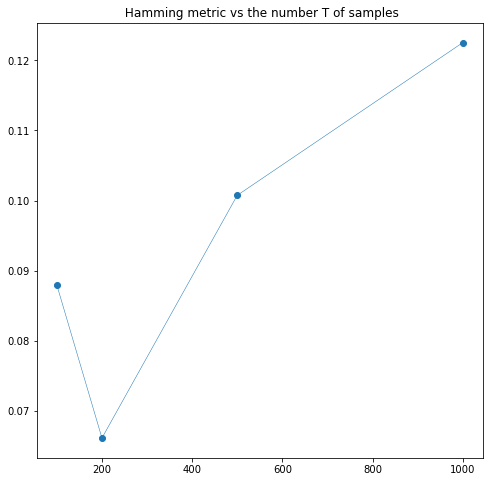

In [9]:
sig = 2 

hamming_List = []

for sample in T:    
    
    indices = index[(index["sigma"]==sig) & (index["sample"]==sample)].index.values
        
    hamming_value = 0 
    
    for i in indices : 
        
        signal_with_noise = simulations[str(i),"signal"]            
        bkps = simulations[str(i),"bkps"] 
        
        algo = rpt.KernelCPD(kernel="linear").fit(signal_with_noise) 
        
        # estimation of the slope
        slope = compute_slope(signal_with_noise, algo, 15, int(0.4 * sample))
        Cslope = -sample*slope
        
        # new penalty
        penalty = Cslope*n_dims/sample
        
        result = algo.predict(pen=penalty)  # minimizes the linearly penalized sum of costs (with beta=10)
        
        hamming_value += hamming(bkps,result)
        
        
    hamming_List.append(hamming_value/len(indices))

plt.figure(figsize = (8,8))   
plt.title(" Hamming metric vs the number T of samples")
plt.plot(T,hamming_List, marker = 'o', linewidth = 0.5)   

# saving the figure
plt.savefig(fname="fig-q3-HammingvsSample.png", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)
plt.show()

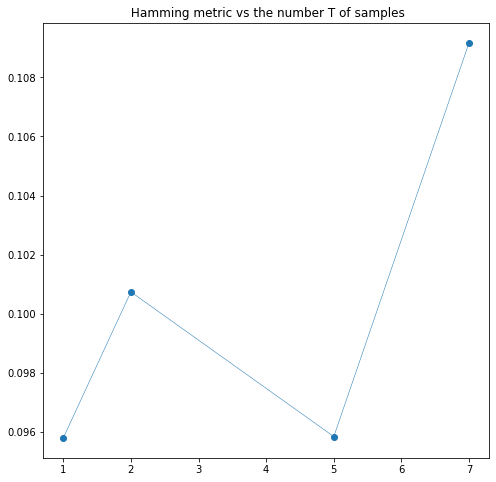

In [10]:
sample = 500

hamming_List = []

for sig in sigma:    
    
    indices = index[(index["sigma"]==sig) & (index["sample"]==sample)].index.values
        
    hamming_value = 0 
    
    for i in indices : 
        
        signal_with_noise = simulations[str(i),"signal"]            
        bkps = simulations[str(i),"bkps"] 
        
        algo = rpt.KernelCPD(kernel="linear").fit(signal_with_noise) 
        
        # estimation of the slope
        slope = compute_slope(signal_with_noise, algo, 15, int(0.4 * sample))
        Cslope = -sample*slope
        
        # new penalty
        penalty = Cslope*n_dims/sample
        
        result = algo.predict(pen=penalty)  # minimizes the linearly penalized sum of costs (with beta=10)
        
        hamming_value += hamming(bkps,result)
        
        
    hamming_List.append(hamming_value/len(indices))

plt.figure(figsize = (8,8))   
plt.title(" Hamming metric vs the number T of samples")
plt.plot(sigma,hamming_List, marker = 'o', linewidth = 0.5)    

# saving the figure
plt.savefig(fname="fig-q3-HammingvsSigma.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)
plt.show()

# Question 4

In [11]:
#kernel functions 

M = 9

def gm_hat(lambd, m, R, lambda_n = 12):
    a = lambda_n/(M+1-R)
    return 0.5*(1+np.cos(2*np.pi*((lambd-a*m)/(a*R)+0.5)))*np.logical_and(-R*a<= lambd - a*m, lambd-a*m < 0)

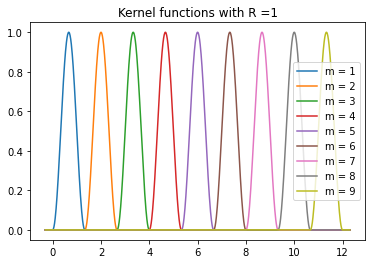

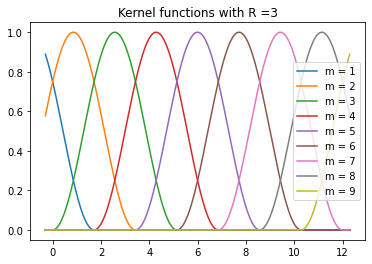

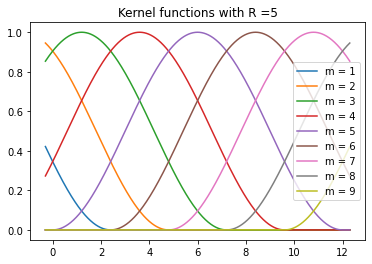

In [12]:
for R in [1,3,5]:
    plt.title("Kernel functions with R =" + str(R))
    for m in range(1,M+1):
        lambd = np.linspace(-0.3,12.3,1000)
        y = [gm_hat(x, m,R) for x in lambd]
        plt.plot(lambd,y, label = "m = " + str(m))
    plt.legend()
    
    # saving the figure
    plt.savefig(fname="fig-q4-kernel-R" + str(R) + ".pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)
    plt.show()

# Question 5

In [13]:
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from scipy.spatial.distance import pdist, squareform
from math import asin, cos, radians, sin, sqrt
from pygsp import graphs
from matplotlib.dates import DateFormatter

In [14]:
data_df, stations_df, description = load_molene_meteo_dataset()

In [15]:
def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def get_exponential_similarity(
    condensed_distance_matrix, bandwidth, threshold
):
    exp_similarity = np.exp(
        -(condensed_distance_matrix ** 2) / bandwidth / bandwidth
    )
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

In [16]:
# convert temperature from Kelvin to Celsius
data_df["temp"] = data_df.t - 273.15  # temperature in Celsius

temperature_df = data_df.pivot(
    index="date", values="temp", columns="station_name"
)

# only keep a subset of stations with no missing values

STATION_LIST = list(temperature_df.columns[temperature_df.isna().sum()==0].values)
STATION_with_missing_values = list(temperature_df.columns[temperature_df.isna().sum()>0].values)


keep_cond = stations_df.Nom.isin(STATION_LIST)
stations_df = stations_df[keep_cond]
keep_cond = data_df.station_name.isin(STATION_LIST)
data_df = data_df[keep_cond].reset_index().drop("index", axis="columns")

In [17]:
stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

In [18]:
print("The stations with missing values are : \n",STATION_with_missing_values)

The stations with missing values are : 
 ['ARZAL', 'BATZ', 'BEG_MEIL', 'BREST-GUIPAVAS', 'BRIGNOGAN', 'CAMARET', 'LANDIVISIAU', 'LANNAERO', 'LANVEOC', 'OUESSANT-STIFF', 'PLOUAY-SA', 'PLOUDALMEZEAU', 'PLOUGONVELIN', 'QUIMPER', 'RIEC SUR BELON', 'SIZUN', 'ST NAZAIRE-MONTOIR', 'VANNES-MEUCON']


In [19]:
sigma = np.median(dist_mat_condensed)  # median heuristic
threshold = 0.83
adjacency_matrix_gaussian = squareform(
    get_exponential_similarity(dist_mat_condensed, sigma, threshold)
)
G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
print(
    f"The graph is {'not ' if not G_gaussian.is_connected(recompute=True) else ''}connected, with {G_gaussian.N} nodes, {G_gaussian.Ne} edges"
)

The graph is connected, with 37 nodes, 75 edges


Limit threshold :  0.83


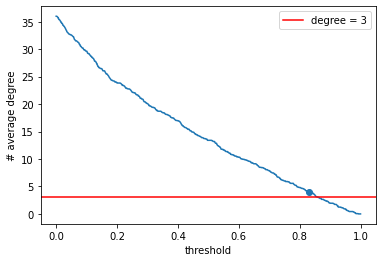

In [20]:
thresholds = np.linspace(0, 1, 1001)
connected = []
average_degree = []

for threshold in thresholds:
    adjacency_matrix = squareform(
        get_exponential_similarity(dist_mat_condensed, sigma, threshold)
    )
    G = graphs.Graph(adjacency_matrix)
    connected.append(G.is_connected())
    average_degree.append(G.d.mean())
    
i = connected.index(False) - 1

print("Limit threshold : ", round(i/len(thresholds),2))

plt.plot(thresholds, average_degree)
plt.ylabel("# average degree")
plt.xlabel("threshold")
plt.scatter([thresholds[i]], [average_degree[i]])
plt.axhline(y=3, label = "degree = 3", color = 'red')
plt.legend()
plt.show()

In [21]:
# drop the NaNs
temperature_df_no_nan = data_df.pivot(
    index="date", values="temp", columns="station_name"
)



laplacian_matrix = G_gaussian.L.todense()

In [22]:
signals = temperature_df_no_nan.to_numpy()
smoothness_arr = np.array(
    [float(signal.T.dot(laplacian_matrix).dot(signal)) for signal in signals]
)
smoothness_df = pd.Series(
    data=smoothness_arr, index=temperature_df_no_nan.index
)

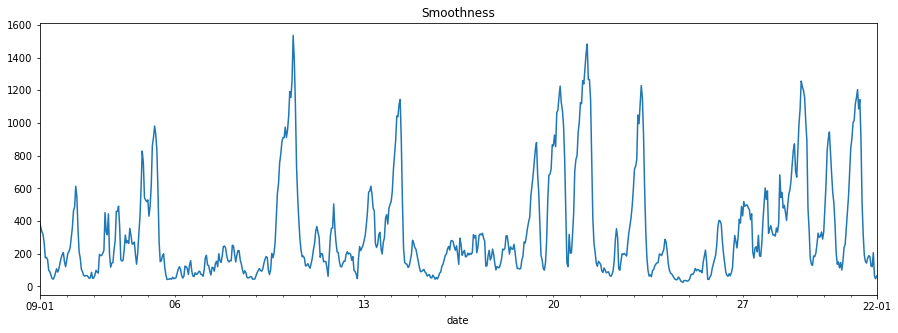

In [23]:
fig, ax = fig_ax()
smoothness_df.plot(ax=ax)
myFmt = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(myFmt)
ax.set_title("Smoothness")
plt.grid(axis="x", color="0.95")

In [24]:
print(f"The signal is the least smooth at {smoothness_df.argmax()}.")
print(f"The signal is the smoothest at {smoothness_df.argmin()}.")

The signal is the least smooth at 225.
The signal is the smoothest at 571.


# Question 6

In [25]:
R = 3

M = 9

# Laplacian eigendecomposition
eigenvals, eigenvects = eigh(laplacian_matrix)

def GWT(signal,m,v):
    lambda_n = eigenvals[-1]
    signal_fourier = eigenvects.T.dot(signal)
    gm = gm_hat(eigenvals, m, R, lambda_n)
    return gm.T.dot(signal_fourier * eigenvects[:, v])

def energy(signal,v,levels):
    e = 0
    for m in levels:
        e+=np.linalg.norm(GWT(signal,m,v))**2
    return e     

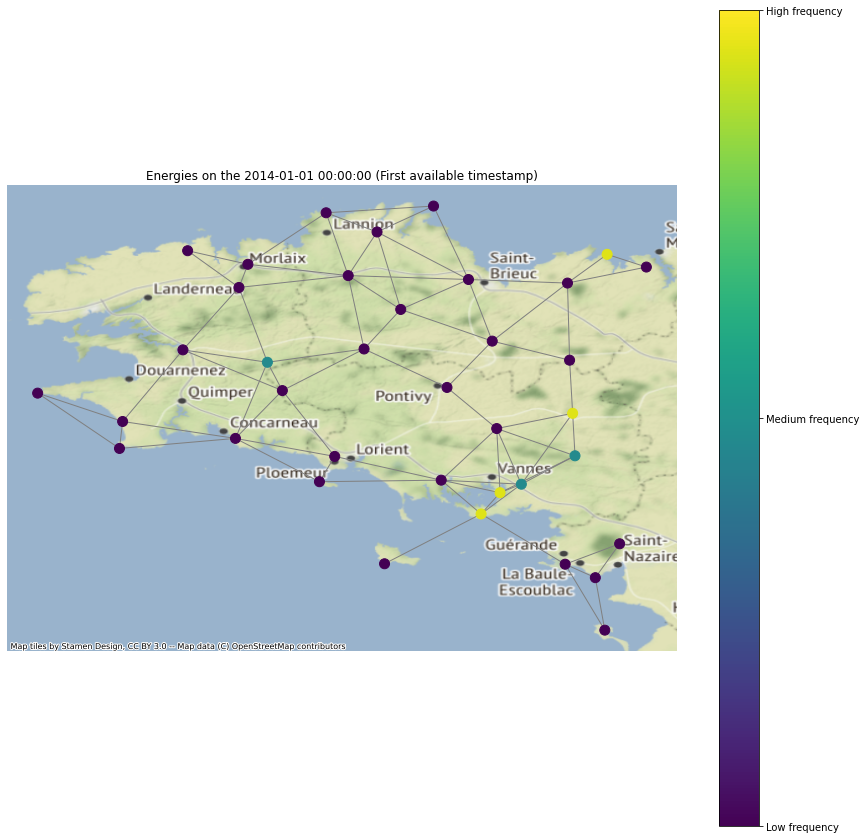

In [26]:
CRS = "EPSG:4326"

signal = signals[0]
colors = []
labels = ["Low frequency","Medium frequency","High frequency"]
for v in range(G_gaussian.N):
    i = np.argmax([energy(signal,v,[1,2,3]),energy(signal,v,[4,5,6]),energy(signal,v,[7,8,9])])
    colors.append(i)

# convert pandas df to geopandas df
stations_gdf = geopandas.GeoDataFrame(
    stations_df,
    geometry=geopandas.points_from_xy(
        stations_df.Longitude, stations_df.Latitude
    ),
).set_crs(CRS)

ax = stations_gdf.geometry.plot(figsize=(15, 15))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(np.array(colors), ax=ax, colorbar = False)

# Plot the colorbar
sc = ax.scatter(*G_gaussian.coords.T,
                        c=np.array(colors))
cbar = plt.colorbar(sc, ticks=range(3))
cbar.ax.set_yticklabels(labels)

# Title
_ = ax.set_title(
    f"Energies on the {temperature_df_no_nan.index[0]} (First available timestamp)"
)

# saving the figure
plt.savefig(fname="fig-q6-first-timestamp.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)

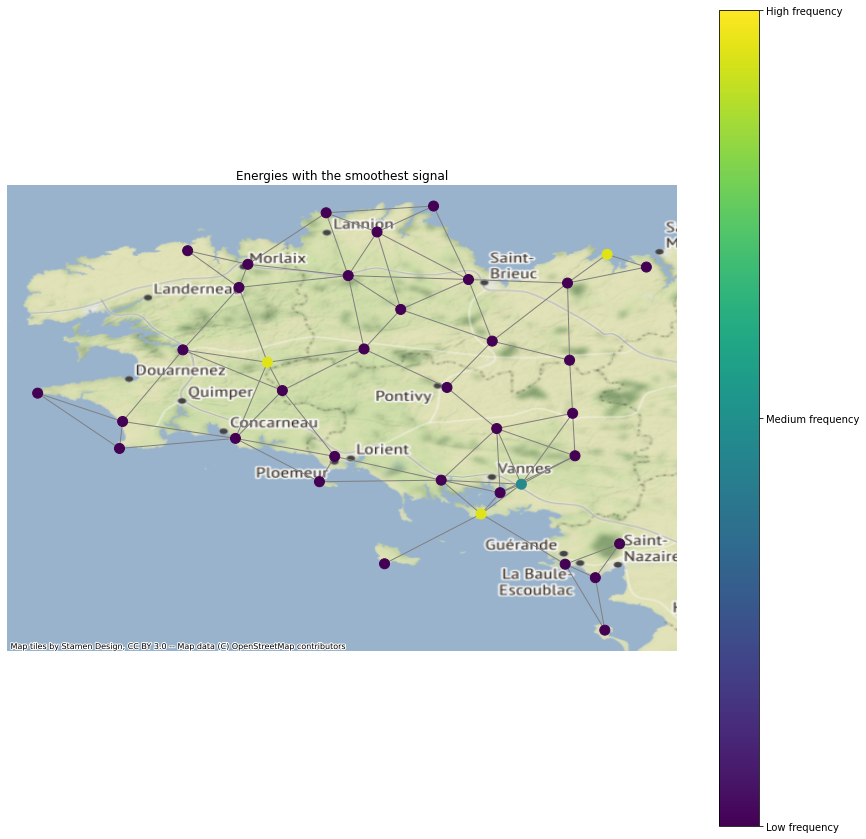

In [27]:
signal = signals[smoothness_df.argmin()]
colors = []
for v in range(G_gaussian.N):
    i = np.argmax([energy(signal,v,[1,2,3]),energy(signal,v,[4,5,6]),energy(signal,v,[7,8,9])])
    colors.append(i)

    
ax = stations_gdf.geometry.plot(figsize=(15, 15))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(np.array(colors), ax=ax, colorbar = False)

# Plot the colorbar
sc = ax.scatter(*G_gaussian.coords.T,
                        c=np.array(colors))
cbar = plt.colorbar(sc, ticks=range(3))
cbar.ax.set_yticklabels(labels)

# Title
_ = ax.set_title(
    f"Energies with the smoothest signal"
)
# saving the figure
plt.savefig(fname="fig-q6-smoothest.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)

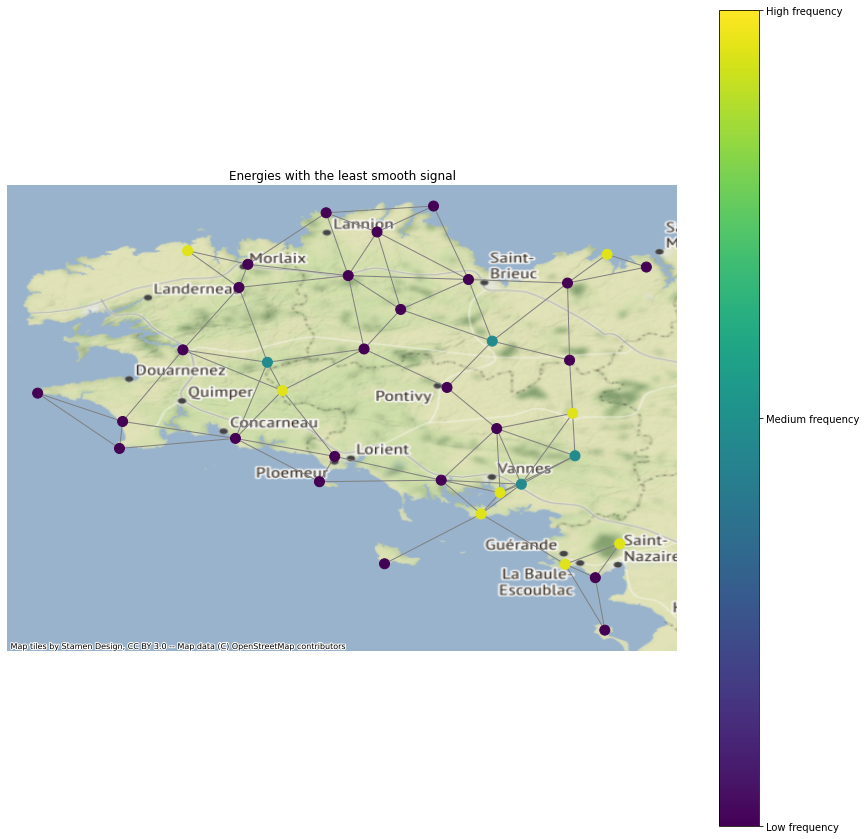

In [28]:
signal = signals[smoothness_df.argmax()]
colors = []
for v in range(G_gaussian.N):
    i = np.argmax([energy(signal,v,[1,2,3]),energy(signal,v,[4,5,6]),energy(signal,v,[7,8,9])])
    colors.append(i)


ax = stations_gdf.geometry.plot(figsize=(15, 15))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(np.array(colors), ax=ax, colorbar = False)

# Plot the colorbar
sc = ax.scatter(*G_gaussian.coords.T,
                        c=np.array(colors))
cbar = plt.colorbar(sc, ticks=range(3))
cbar.ax.set_yticklabels(labels)

# Title
_ = ax.set_title(
    f"Energies with the least smooth signal"
)

# saving the figure
plt.savefig(fname="fig-q6-leastsmooth.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)

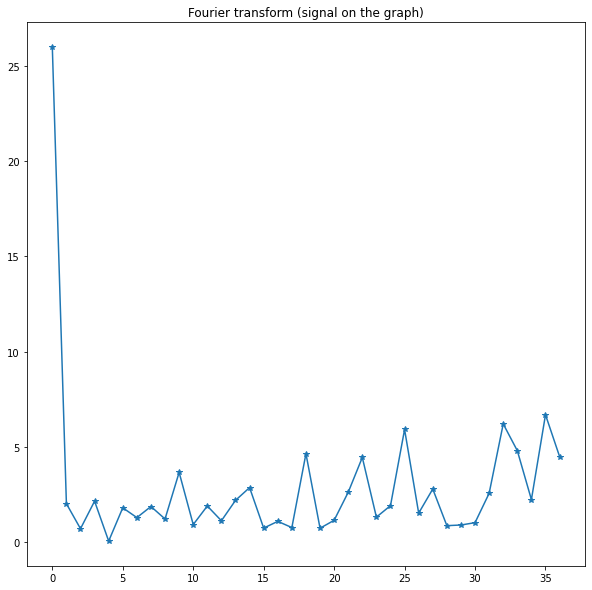

In [29]:
# Fourier transform
signal_fourier = eigenvects.T.dot(signal)

# plot
plt.figure(figsize=(10,10))
plt.title("Fourier transform (signal on the graph)")
plt.plot(abs(signal_fourier), "*-")
plt.show()

# Question 7

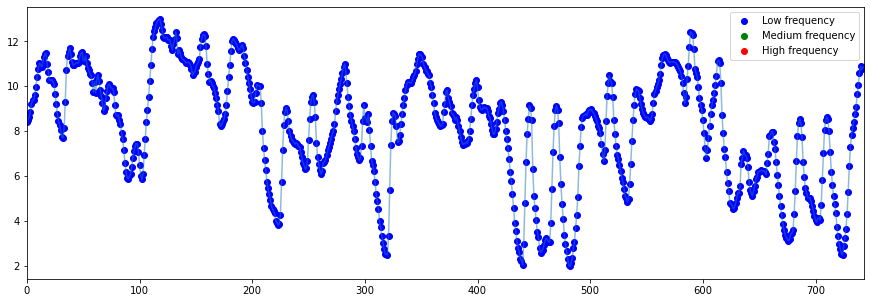

In [30]:
T, V = signals.shape

class_array = np.zeros(T, dtype = int)
y = np.zeros(T)

for timestamp in range(T):
    average_temperature = signals[timestamp].mean()
    y[timestamp] = average_temperature
    
    frequency = np.array([0,0,0])
    for v in range(G_gaussian.N):
        signal = signals[timestamp]
        i = np.argmax([energy(signal,v,[1,2,3]),energy(signal,v,[4,5,6]),energy(signal,v,[7,8,9])])
        frequency[i]+=1
    class_array[timestamp] = np.argmax(frequency)
        
x = np.arange(y.shape[0])
colors = ["b", "g", "r"]  # three colours=three classes
color_array = np.take(colors, class_array)

fig, ax = fig_ax()

low_freq = np.where(color_array == 'b')
medium_freq = np.where(color_array == 'g')
high_freq = np.where(color_array == 'r')
ax.scatter(x[low_freq], y[low_freq], c='b')
ax.scatter(x[medium_freq], y[medium_freq], c='g')
ax.scatter(x[high_freq], y[high_freq], c='r')
ax.legend(labels)
ax.plot(x, y, alpha=0.5)

# saving the figure
plt.savefig(fname="fig-q7-avgtemp.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)
plt.show()

# Question 8

In [31]:
def get_line_graph(n_nodes=10) -> graphs.Graph:
    """Return a line graph."""
    adjacency_matrix = np.eye(n_nodes)
    adjacency_matrix = np.c_[adjacency_matrix[:, -1], adjacency_matrix[:, :-1]]
    adjacency_matrix[-1,0] = 0
    adjacency_matrix += adjacency_matrix.T
    line_graph = graphs.Graph(adjacency_matrix)
    line_graph.set_coordinates(kind="line2D")
    line_graph.compute_laplacian("combinatorial")
    return line_graph

/Users/macrafa/opt/anaconda3/lib/python3.8/site-packages/pygsp/plotting.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show(warn=False)


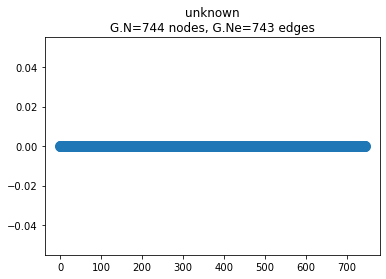

In [32]:
time_graph = get_line_graph(T) 
time_graph.plot()

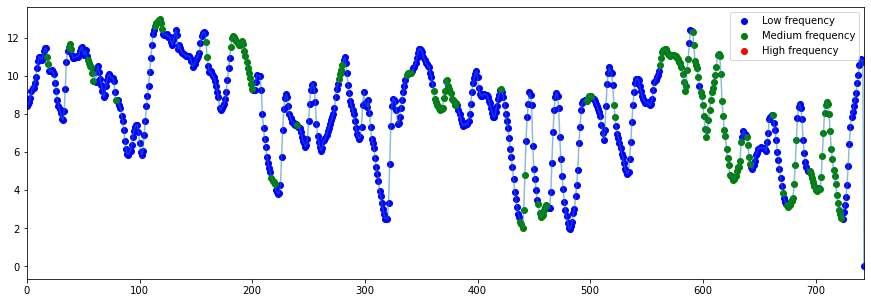

In [33]:
# Paramaters 
R = 3
M = 9

# Laplacian eigendecomposition
eigenvals_space, eigenvects_space = eigh(laplacian_matrix)
eigenvals_time, eigenvects_time = eigh(time_graph.L.todense())

eigenvals_space = eigenvals_space.reshape(-1,1)
eigenvals_time = eigenvals_time.reshape(1,-1)

cartesian_eigenvects = np.kron(eigenvects_space.T,eigenvects_time.T)
cartesian_eigenvalues = (eigenvals_space + eigenvals_time).reshape(-1)

# signal time x space (744,37)
signal = signals.ravel()

# class initialization
time_space = signal.shape[0]
class_array_time_space = np.zeros(time_space, dtype = int)

T, V = time_graph.N, G_gaussian.N
y = np.zeros(T)
class_array = np.zeros(T, dtype = int)


# intermediate computations
lambda_n = np.max(cartesian_eigenvalues)
signal_fourier = cartesian_eigenvects.dot(signal)

def GWT_spacetime(m,v):
    gm = gm_hat(cartesian_eigenvalues, m, R, lambda_n)
    return gm.T.dot(signal_fourier * cartesian_eigenvects[v, :])


def energy_spacetime(v,levels):
    e = 0
    for m in levels:
        e+=np.linalg.norm(GWT_spacetime(m,v))**2
    return e    


# Compute the frequency of each node                      
for v in range(time_space):

    i = np.argmax([energy_spacetime(v,[1,2,3]),
                   energy_spacetime(v,[4,5,6]),
                   energy_spacetime(v,[7,8,9])])
    class_array_time_space[v] = i
    

for timestamp in range(T-1):


    average_temperature = signal[timestamp*V:(timestamp+1)*V].mean()
    y[timestamp] = average_temperature
    
    frequency = np.array([0,0,0])
    for v in range(V):
        i = class_array_time_space[timestamp*V + v]
        frequency[i]+=1
    class_array[timestamp] = np.argmax(frequency)  

x = np.arange(y.shape[0])

colors = ["b", "g", "r"]  # three colours=three classes
color_array = np.take(colors, class_array)
fig, ax = fig_ax()

low_freq = np.where(color_array == 'b')
medium_freq = np.where(color_array == 'g')
high_freq = np.where(color_array == 'r')
ax.scatter(x[low_freq], y[low_freq], c='b')
ax.scatter(x[medium_freq], y[medium_freq], c='g')
ax.scatter(x[high_freq], y[high_freq], c='r')
ax.legend(labels)
ax.plot(x, y, alpha=0.5)

# saving the figure
plt.savefig(fname="fig-q8-avgtemp.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)
plt.show()